In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm
import random

In [10]:
%load_ext autoreload
%autoreload 2
from base import utils, datahandler, prediction_models, evaluation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir)

In [13]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']
reduced_input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)']

In [6]:
some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:100]}

In [14]:
ds_gen = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=reduced_input_features,
                                      label_features=['EW', 'NS'],
                                      train_val_split=0.99, stride=1,
                                      input_history_steps=8, input_future_steps=8, seed=69)

=========================Creating Dataset=========================
Seed: 69
nTrain: 247 nVal: 3 (0.99)
Padding: True
Scaling: True
Labels: ['EW_encoded', 'NS_encoded']


2024-01-06 17:12:55.512114: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 619846272 exceeds 10% of free system memory.
2024-01-06 17:12:56.443252: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 619846272 exceeds 10% of free system memory.


=========================Finished Dataset=========================


In [15]:
train_combined, val_combined = ds_gen.get_datasets(256, label_features=['EW', 'NS'], shuffle=True)
print(train_combined.element_spec)


(TensorSpec(shape=(None, 16, 9), dtype=tf.float64, name=None), {'EW': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'NS': TensorSpec(shape=(None,), dtype=tf.int32, name=None)})


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 16, 9)]              0         []                            
                                                                                                  
 conv1d_2 (Conv1D)           (None, 11, 64)               3520      ['Input[0][0]']               
                                                                                                  
 conv1d_3 (Conv1D)           (None, 6, 64)                24640     ['conv1d_2[0][0]']            
                                                                                                  
 flatten_1 (Flatten)         (None, 384)                  0         ['conv1d_3[0][0]']            
                                                                                            

/home/david/Code/splid-challenge/base/prediction_models.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/home/david/miniconda3/envs/splid-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


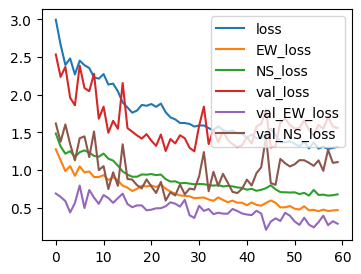

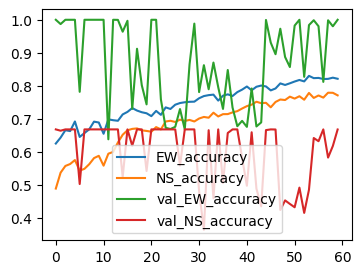

In [16]:
#dense_combined_model = prediction_models.Dense_NN(train_combined, dense_layers=[256,128,64], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
#dense_combined_model = prediction_models.CNN(train_combined, conv_layers=[[128,3],[128,3],[128,3]], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
#dense_combined_model = prediction_models.Dense_NN(train_combined, dense_layers=[256,128,64], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[20000,0.8], seed=0)
dense_combined_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[[64,6],[64,6]], dense_layers=[128,64,32], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[25000,0.9], seed=0)


dense_combined_model.summary()
hist = dense_combined_model.fit(train_combined, val_ds=val_combined, target_metric='val_loss', epochs=150, verbose=1, plot_hist=False, callbacks=[], early_stopping=30)
dense_combined_model.plot_hist(hist, [k for k in hist.history.keys() if 'loss' in k])
dense_combined_model.plot_hist(hist, [k for k in hist.history.keys() if 'accuracy' in k])
dense_combined_model.model.save("conv_model.hdf5")


Starting training. Optimizing "val_accuracy"
Epoch 1/30
2102/2102 [==============================] - 30s 14ms/step - loss: 1.0762 - EW_loss: 0.3581 - NS_loss: 0.5458 - EW_accuracy: 0.8658 - NS_accuracy: 0.8126 - val_loss: 1.5300 - val_EW_loss: 0.4726 - val_NS_loss: 0.8851 - val_EW_accuracy: 0.7277 - val_NS_accuracy: 0.6685
Epoch 2/30
2102/2102 [==============================] - 29s 14ms/step - loss: 1.1180 - EW_loss: 0.3755 - NS_loss: 0.5702 - EW_accuracy: 0.8545 - NS_accuracy: 0.8066 - val_loss: 1.4276 - val_EW_loss: 0.3584 - val_NS_loss: 0.8966 - val_EW_accuracy: 0.7943 - val_NS_accuracy: 0.6685
Epoch 3/30
2102/2102 [==============================] - 30s 14ms/step - loss: 1.0939 - EW_loss: 0.3678 - NS_loss: 0.5533 - EW_accuracy: 0.8583 - NS_accuracy: 0.8104 - val_loss: 1.5038 - val_EW_loss: 0.4599 - val_NS_loss: 0.8706 - val_EW_accuracy: 0.7177 - val_NS_accuracy: 0.6526
Epoch 4/30
2102/2102 [==============================] - 30s 14ms/step - loss: 1.0796 - EW_loss: 0.3541 - NS_loss: 0

/home/david/Code/splid-challenge/base/prediction_models.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


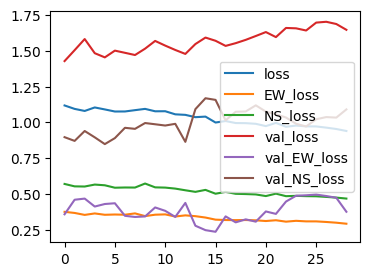

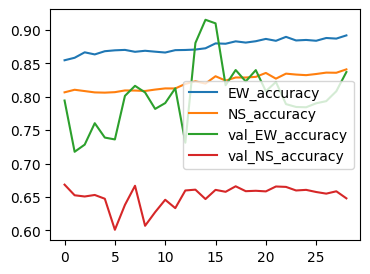

In [24]:
hist = dense_combined_model.fit(train_combined, val_ds=val_combined, epochs=30, verbose=1, plot_hist=False, callbacks=[])
dense_combined_model.plot_hist(hist, [k for k in hist.history.keys() if 'loss' in k])
dense_combined_model.plot_hist(hist, [k for k in hist.history.keys() if 'accuracy' in k])

In [25]:
dense_combined_model.model.save("conv_model.hdf5")


/home/david/miniconda3/envs/splid-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
def prepare_submission_df(ds, model, model_output_features, label_decoders, smoothing=False, smoothing_past_steps=3, smoothing_fut_steps=10):
    '''Prepare dataframes for submission based on models predictions. The output_labels need to be in the same order as they were when creating the dataset!'''
    assert(len(model_output_features) == len(label_decoders))
    inputs = np.concatenate([element for element in ds.map(lambda x,y,z: x).as_numpy_iterator()])
    identifiers = np.concatenate([element for element in ds.map(lambda x,y,z: z).as_numpy_iterator()])
    
    df = pd.DataFrame(np.concatenate([identifiers.reshape(-1,2)], axis=1), columns=['ObjectID', 'TimeIndex'], dtype=np.int32)

    preds = model.predict(inputs)
    for ft_idx, feature in enumerate(model_output_features):
        labels = np.concatenate([element[feature] for element in ds.map(lambda x,y,z: y).as_numpy_iterator()])
        labels_decoded = label_decoders[ft_idx].inverse_transform(labels)
        preds_argmax = np.argmax(preds[ft_idx], axis=1) if len(model_output_features)>1 else np.argmax(preds, axis=1)
        preds_decoded = label_decoders[ft_idx].inverse_transform(preds_argmax)
        df[f'{feature}'] = labels_decoded
        df[f'Predicted_{feature}'] = preds_decoded
    if smoothing:
        df = utils.smooth_predictions(df, past_steps=smoothing_past_steps, fut_steps=smoothing_fut_steps)
    return df


In [27]:
def evaluate_submission_df(prepared_df, ground_truth):
    results = utils.convert_classifier_output(prepared_df).sort_values(['ObjectID']).reset_index(drop=True)
    evaluator = evaluation.NodeDetectionEvaluator(ground_truth, results)
    precision, recall, f2, rmse, total_tp, total_fp, total_fn = evaluator.score()
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F2: {f2:.2f}')
    print(f'RMSE: {rmse:.4}')
    print(f'TP: {total_tp} FP: {total_fp} FN: {total_fn}')

In [28]:
ground_truth = pd.read_csv(challenge_data_dir / 'train_labels.csv')
ground_truth_train = ground_truth[ground_truth['ObjectID'].isin(map(int, ds_gen.train_keys))].copy()
ground_truth_val = ground_truth[ground_truth['ObjectID'].isin(map(int, ds_gen.val_keys))].copy()

train_EW, val_EW = ds_gen.get_datasets(256, label_features=['EW', 'NS'], shuffle=False, keep_identifier=True)

In [29]:
df_train=prepare_submission_df(ds=train_EW, model=dense_combined_model.model, model_output_features=['EW', 'NS'],
                               label_decoders=[ds_gen.combined_label_encoder, ds_gen.combined_label_encoder],
                               smoothing=True, smoothing_past_steps=10, smoothing_fut_steps=10)


# Dense result: F2 0.49/0.32 (t/v)
# Dense result(w/ future): F2 0.46/0.45 (t/v) (256/128/54)

# Conv result (no future): F2 0.53/0.37
# Conv result (w/ future): F2 0.51/0.38

16815/16815 [==============================] - 55s 3ms/step


Smoothing: 100%|██████████| 247/247 [03:21<00:00,  1.23it/s]


In [30]:
evaluate_submission_df(df_train, ground_truth_train)


Precision: 0.16
Recall: 0.51
F2: 0.35
RMSE: 1.339
TP: 508 FP: 2751 FN: 480


In [24]:
train_EW, val_EW = ds_gen.get_datasets(256, label_features=['EW', 'NS'], shuffle=False, keep_identifier=True)
df_val=prepare_submission_df(ds=val_EW, model=dense_combined_model.model, model_output_features=['EW', 'NS'],
                                label_decoders=[ds_gen.combined_label_encoder, ds_gen.combined_label_encoder],
                               smoothing=True, smoothing_past_steps=5, smoothing_fut_steps=5)
evaluate_submission_df(df_val, ground_truth_val)


1020/1020 [==============================] - 3s 3ms/step


Smoothing: 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Precision: 0.18
Recall: 0.56
F2: 0.40
RMSE: 1.099
TP: 29 FP: 130 FN: 23


In [17]:
print(ds_gen.val_keys)

['24', '159', '39', '36', '101', '104', '5', '133', '32', '46', '78', '122', '128', '154', '16']


In [1]:
dense_combined_model.model.save("tmp_model.hdf5")

NameError: name 'dense_combined_model' is not defined